# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

## Импортирование и предварительная настройка

In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 9)
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'png'

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import text 

try:
    import missingno as msno
except ModuleNotFoundError as E:
    print('{}: {}'.format(type(E), E))
    msno = None

from IPython.display import display, Markdown
import warnings
warnings.simplefilter('ignore')

## Данные

In [2]:
dataframe = pd.read_excel('geo_comment.xlsx')

In [3]:
dataframe.head(3)

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70382 entries, 0 to 70381
Data columns (total 5 columns):
x                70382 non-null float64
y                70382 non-null float64
comment_class    70382 non-null int64
multiplier       70382 non-null int64
comment          70382 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 3.2+ MB


## Нормализация

In [5]:
class SelectedColumnsOnlyScaler(BaseEstimator, TransformerMixin):
    """ класс для нормализации определённых столбцов"""

    def __init__(self, columns, copy=True, with_mean=True, with_std=True):
        self.scaler = StandardScaler(copy, with_mean, with_std)
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]),
                                columns=self.columns,
                                index=X.index)
        X_not_scaled = X.ix[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [6]:
columns_to_normalize = ['x', 'y', 'comment_class']
scaler = SelectedColumnsOnlyScaler(columns_to_normalize)
scaler.fit(dataframe)
df = scaler.transform(dataframe)

In [7]:
df.head(3)

,x,y,comment_class,multiplier,comment
0,0.173634,-0.129236,-0.449492,1,Во все разделы правил землепользования и застр...
1,0.173634,-0.129236,-0.449492,1,На основании вступившего в законную силу судеб...
2,0.107665,-0.662964,-0.449492,1,Внести в Проект правил землепользования и заст...


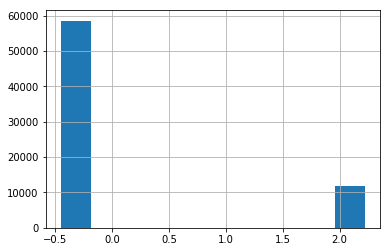

In [8]:
df['comment_class'].hist()

## Кластеризация по координатам

In [9]:
# 12 - число округов Москвы
X_scaled = df[['x', 'y']]

In [10]:
# кластеризуем
algorithm = KMeans(n_clusters=12, n_jobs=-1)
clusters = algorithm.fit_predict(X_scaled)

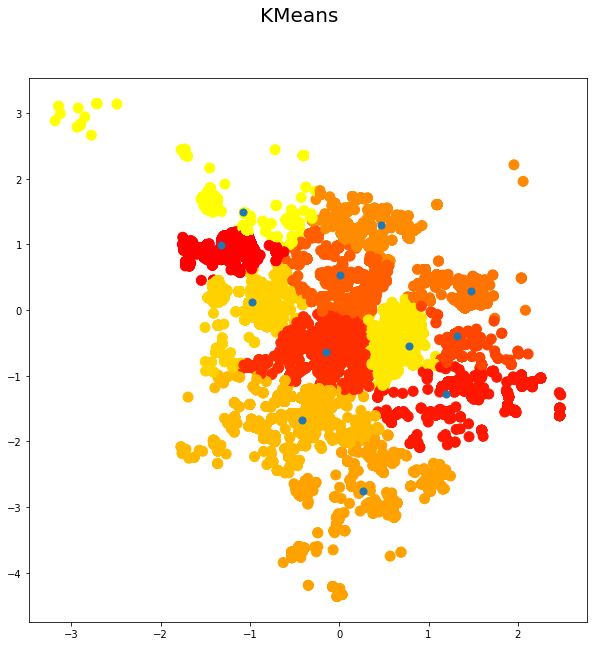

In [11]:
# выводим картинку
fig = plt.figure(figsize=(10, 10))
plt.scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c=clusters, cmap='autumn', s=100)
fig.suptitle(algorithm.__class__.__name__, fontsize=20)

centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=50)

## Отобразим голоса за/против

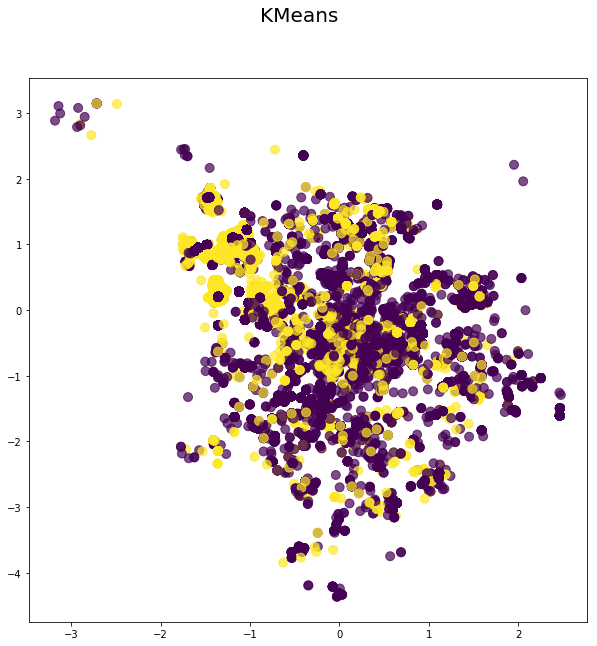

In [12]:
# выводим картинку
fig = plt.figure(figsize=(10, 10))
fig.suptitle(algorithm.__class__.__name__, fontsize=20)
plt.scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c=df['comment_class'], s=80, alpha=0.7)

## Подбор оптимального количества кластеров

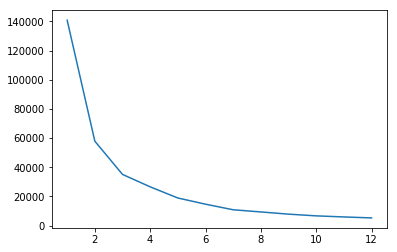

In [13]:
k_inertia = []
ks = range(1,13)
for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)
plt.plot(ks, k_inertia)

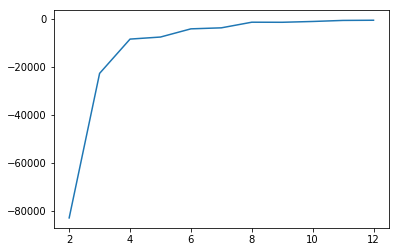

In [14]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

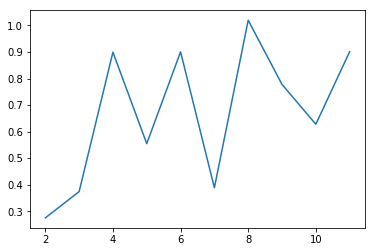

In [15]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [16]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

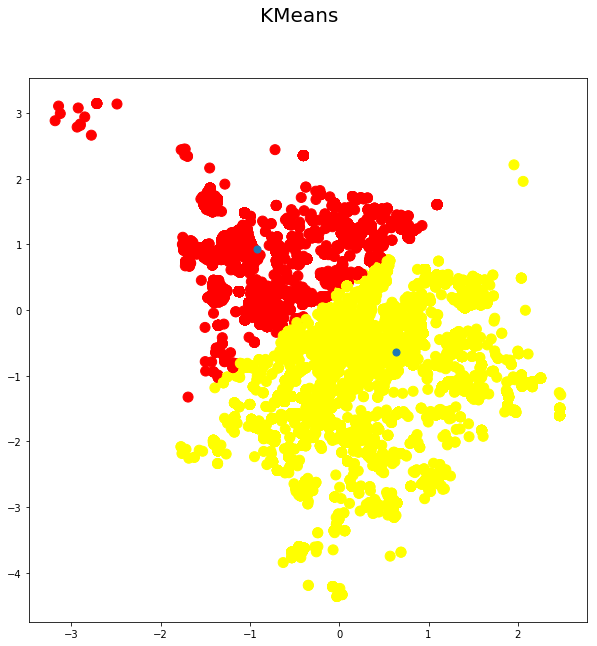

In [17]:
algorithm = KMeans(n_clusters=k_opt)
clusters = algorithm.fit_predict(X_scaled)

fig = plt.figure(figsize=(10, 10))
plt.scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c=clusters, cmap='autumn', s=100)
fig.suptitle(algorithm.__class__.__name__, fontsize=20)

centers = algorithm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=50)

## Наиболее активные в голосовании районы

In [18]:
X_scaled = df[['x', 'y']]

In [23]:
# кластеризуем
DBSCAN_algorithm = DBSCAN(n_jobs=-1)
DBSCAN_clusters = DBSCAN_algorithm.fit_predict(X_scaled)

Text(0.5,0.98,'DBSCAN')

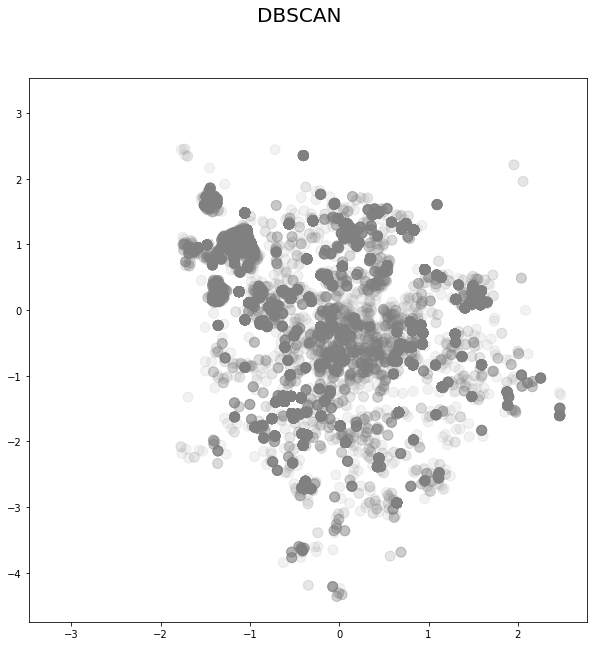

In [28]:
# выводим картинку
fig = plt.figure(figsize=(10, 10))
plt.scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c=DBSCAN_clusters, cmap='gray',
            s=100, alpha=0.1)
fig.suptitle(DBSCAN_algorithm.__class__.__name__, fontsize=20)

## Основные тематики комментариев жителей

In [43]:
russian_stop_words = set(line.strip() for line in open('stop-words-russian.txt', encoding='UTF8'))

In [45]:
stop_words = text.ENGLISH_STOP_WORDS.union(russian_stop_words)

In [46]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words=stop_words)

X = vectorizer.fit_transform(df.comment)

In [48]:
km = KMeans(n_clusters=12, init='k-means++', max_iter=100, n_init=1, n_jobs=-1)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=12, n_init=1, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [51]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(12):
    print("Cluster %d:" % (i + 1), end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 1: комплекса ленинградского природного природоохранной тпу северного 2010 округа участке зон
Cluster 2: гпзу публичных слушаний жилой проведения вернуть образовательное учреждение 191000 группы
Cluster 3: возражаем улицей любого 77 категорически плотности пзз существующей кв москва
Cluster 4: парковая нового поддерживаю нашего района детей 46 размещение развития 11
Cluster 5: книга стр функциональной 43 живописная спортивно плану регламент соответствии градостроительный
Cluster 6: пзз рф земельных участков кодекса градостроительного ст использования разрешенного соответствии
Cluster 7: митино метро тпу станции пятницкое станций близлежащих митинская таюке настоящее
Cluster 8: молот серп энтузиастов отвести проездом 23 требуем завода производственной шоссе
Cluster 9: разрешённого 04 спортивных участок указанный размещение номер 77 вида кадастровый
Cluster 10: 91 свободы пзз 45 оопт особо ст природной охраняемой согласно
Cluster 11: корп панфиловцев героев придомовой внутри предп